# Transfer Learning

In which I harness the power of pre-trained models to improve my own. I'll be using models that Keras provides in the `keras.applications` library and which have been trained on the ImageNet dataset.

I'll start by using the pre-trained models as a base, simply adding fully connected layers on top and a simple sigmoid-activated 1-node output layer.

A useful reference for this has been: https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/

In [27]:
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras.layers import Dense, Flatten, Dropout
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from pickle import dump

from functions import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data
I'll go ahead and try this out on the full dataset, including new data from this past weekend.

In [40]:
# Image folder for training
train_dir = 'input_images/full_combined'

# Delete metadata files created by Mac OS
!find . -name ".DS_Store" -delete

### VGG-16 as base model

Use weights from training on ImageNet, but leave out last 3 (fully connected) layers so I can add my own output layer(s).

In [20]:
# Make generators with image aug as before
train_datagen = ImageDataGenerator(rescale=1./255, 
                                    validation_split=0.1,
                                    horizontal_flip=True,
                                    rotation_range=20, 
                                    brightness_range=[0.5, 1.5], 
                                    zoom_range=.2)

vgg_train_gen = train_datagen.flow_from_directory(train_dir, subset='training', class_mode='binary')
vgg_val_gen = train_datagen.flow_from_directory(train_dir, subset='validation', class_mode='binary', shuffle=False)

Found 1548 images belonging to 2 classes.
Found 171 images belonging to 2 classes.


In [16]:
vgg_base_model = VGG16(weights='imagenet', 
                       include_top=False,
                       input_shape=(256, 256, 3))

In [17]:
# Freeze layers
for layer in vgg_base_model.layers:
    layer.trainable = False

In [18]:
# Check architecture
vgg_base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

Note that `Trainable params: 0` means that the layers/weights have been successfully frozen.

### Add final fully connected layers

Final layers with sigmoid output. For this first try, I'll just add one Dense(512) layer and an output layer. Might experiment with dropout layers later.

In [22]:
# Instantiate model
vgg_transfer_model = models.Sequential()

# Add base model
vgg_transfer_model.add(vgg_base_model)

# Flatten the output layer to 1 dimension
vgg_transfer_model.add(Flatten())

# Add a fully connected layer with 512 hidden units and ReLU activation
vgg_transfer_model.add(Dense(512, activation='relu'))

# Add a final sigmoid layer with 1 node for classification output
vgg_transfer_model.add(Dense(1, activation='sigmoid'))

# Compile
vgg_transfer_model.compile(optimizer='adam', 
                       loss='binary_crossentropy', 
                       metrics=['acc', 'Recall', 'Precision'])

In [23]:
# Train the model
vgg_history = vgg_transfer_model.fit(vgg_train_gen,
                                     epochs=20,
                                     validation_data=vgg_val_gen)

Epoch 1/20
49/49 [==============================] - 317s 6s/step - loss: 1.5138 - acc: 0.7087 - recall: 0.7083 - precision: 0.7183 - val_loss: 0.2453 - val_acc: 0.9064 - val_recall: 0.9545 - val_precision: 0.8750
Epoch 2/20
49/49 [==============================] - 326s 7s/step - loss: 0.3317 - acc: 0.8579 - recall: 0.8409 - precision: 0.8763 - val_loss: 0.2073 - val_acc: 0.9181 - val_recall: 0.9318 - val_precision: 0.9111
Epoch 3/20
49/49 [==============================] - 333s 7s/step - loss: 0.2913 - acc: 0.8786 - recall: 0.8586 - precision: 0.8995 - val_loss: 0.2840 - val_acc: 0.8655 - val_recall: 0.9773 - val_precision: 0.8037
Epoch 4/20
49/49 [==============================] - 300s 6s/step - loss: 0.3273 - acc: 0.8598 - recall: 0.8598 - precision: 0.8653 - val_loss: 0.1989 - val_acc: 0.9357 - val_recall: 0.9318 - val_precision: 0.9425
Epoch 5/20
49/49 [==============================] - 303s 6s/step - loss: 0.2732 - acc: 0.8863 - recall: 0.8763 - precision: 0.8990 - val_loss: 0.228

In [24]:
vgg_transfer_model.save('models/vgg_transfer_model.h5')

Training eval:
49/49 [==============================] - 291s 6s/step - loss: 0.2901 - acc: 0.8876 - recall: 0.7828 - precision: 0.9968

Validation eval:
6/6 [==============================] - 24s 4s/step - loss: 0.2772 - acc: 0.9064 - recall: 0.8523 - precision: 0.9615


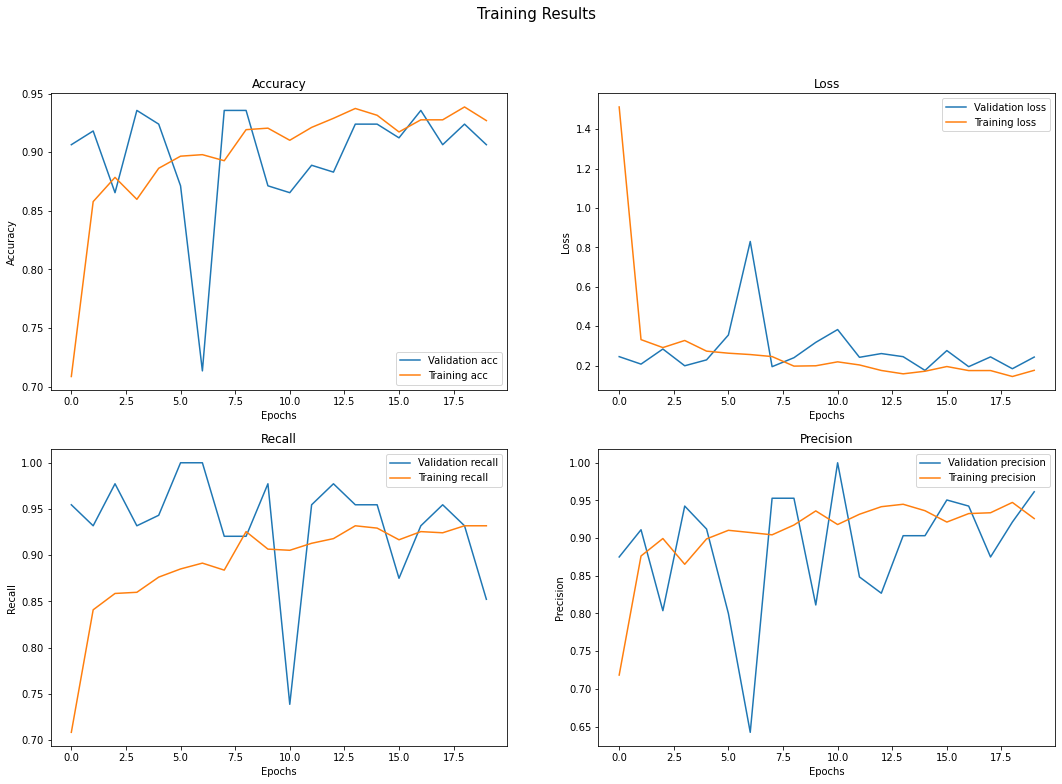

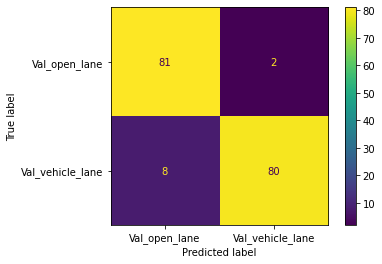

In [25]:
visualize_results(vgg_history, vgg_transfer_model, vgg_train_gen, vgg_val_gen)

In [26]:
dump(vgg_history.history, open('models/vgg_history.pkl', 'wb'))

Seems promising! Metrics are better for training, comparable to my last CNN model for validation, but don’t seem to be overfit. Also trained on full dataset (new and old data), so not exactly the same training dataset as before—does make it difficult to compare. I do now want to go back and re-train my last best model on the full dataset to see what it looks like, since it took way less time train originally and had similar metrics.

**Looking with Lime:**

Let's see what the model is doing!


Predicted class: [0.]
Actual class: 0.0


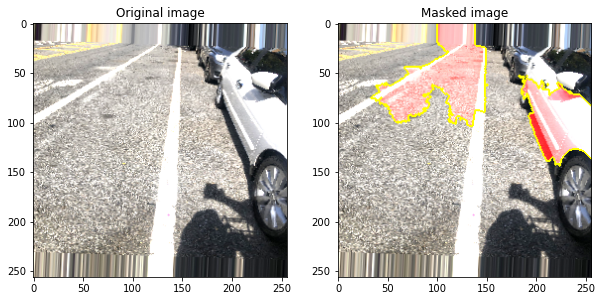

In [29]:
show_explanation(generator=vgg_val_gen, model=vgg_transfer_model)

Are the colors reversed? Or is this model just doing a miraculous job making the right prediction for the wrong reasons?

In [45]:
limedatagen = ImageDataGenerator(rescale=1./255)
limegen = limedatagen.flow_from_directory(train_dir, class_mode='binary', shuffle=True, batch_size=1)

Found 1719 images belonging to 2 classes.



Predicted class: [1.]
Actual class: 1.0


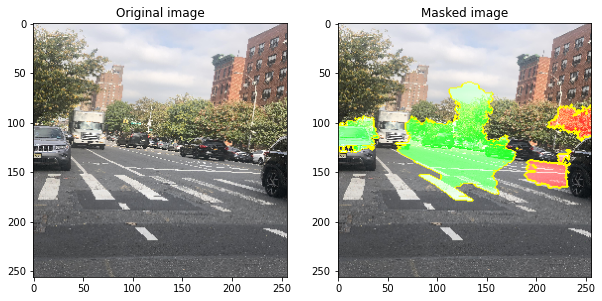

In [46]:
show_explanation(generator=limegen, model=vgg_transfer_model)


Predicted class: [0.]
Actual class: 1.0


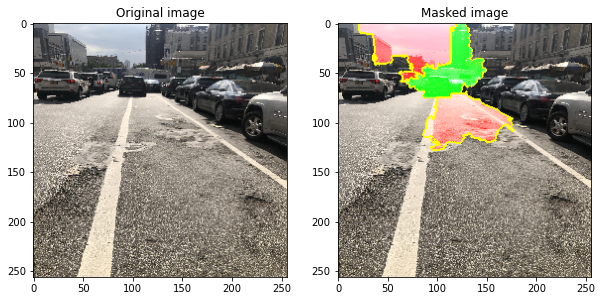

In [47]:
show_explanation(generator=limegen, model=vgg_transfer_model)

This is really strange. The model has excellent metrics, but so far it looks like Lime is showing that it doesn't actually know what it's doing...It really just looks like the colors are reversed because the predicted vs actual classes are correct.


Predicted class: [0.]
Actual class: 1.0


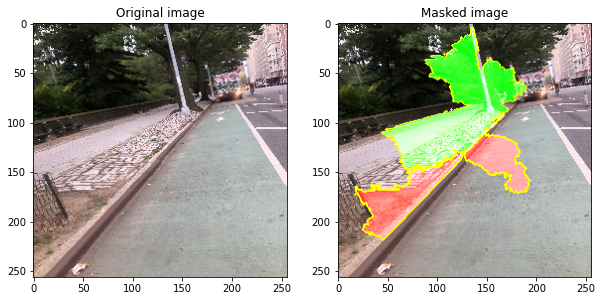

In [48]:
show_explanation(generator=limegen, model=vgg_transfer_model)


Predicted class: [1.]
Actual class: 1.0


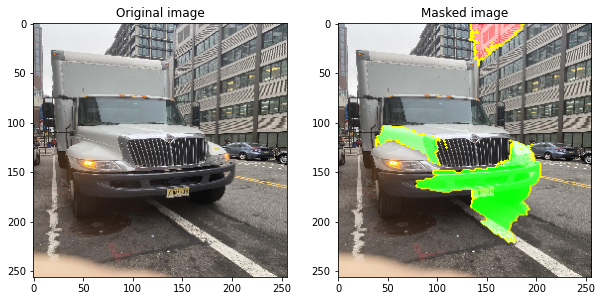

In [49]:
show_explanation(generator=limegen, model=vgg_transfer_model)

### InceptionV3 as base model

In [41]:
# Make generators
train_datagen = ImageDataGenerator(rescale=1./255, 
                                    validation_split=0.1,
                                    horizontal_flip=True,
                                    rotation_range=20, 
                                    brightness_range=[0.5, 1.5], 
                                    zoom_range=.2)

incep_train_gen = train_datagen.flow_from_directory(train_dir, subset='training', class_mode='binary')
incep_val_gen = train_datagen.flow_from_directory(train_dir, subset='validation', class_mode='binary', shuffle=False)

Found 1548 images belonging to 2 classes.
Found 171 images belonging to 2 classes.


In [42]:
# Load InceptionV3 model as base
incep_base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

87916544/87910968 [==============================] - 7s 0us/step


In [43]:
# Freeze layers
for layer in incep_base_model.layers:
    layer.trainable = False

In [44]:
# Check architecture
incep_base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

Add fully connected layers:

In [50]:
# Instantiate model
incep_transfer_model = models.Sequential()

# Add base model
incep_transfer_model.add(incep_base_model)

# Flatten the output layer to 1 dimension
incep_transfer_model.add(Flatten())

# Add a fully connected layer with 512 hidden units and ReLU activation
incep_transfer_model.add(Dense(512, activation='relu'))

# Add a final sigmoid layer with 1 node for classification output
incep_transfer_model.add(Dense(1, activation='sigmoid'))

# Compile
incep_transfer_model.compile(optimizer='adam', 
                       loss='binary_crossentropy', 
                       metrics=['acc', 'Recall', 'Precision'])

In [51]:
# Train the model
incep_history = incep_transfer_model.fit(incep_train_gen,
                                         epochs=20,
                                         validation_data=incep_val_gen)

Epoch 1/20
49/49 [==============================] - 330s 7s/step - loss: 6.9310 - acc: 0.7855 - recall: 0.7854 - precision: 0.7934 - val_loss: 0.8561 - val_acc: 0.9298 - val_recall: 0.9545 - val_precision: 0.9130
Epoch 2/20
49/49 [==============================] - 300s 6s/step - loss: 1.2557 - acc: 0.8488 - recall: 0.8523 - precision: 0.8523 - val_loss: 0.5794 - val_acc: 0.9006 - val_recall: 0.8636 - val_precision: 0.9383
Epoch 3/20
49/49 [==============================] - 280s 6s/step - loss: 0.9324 - acc: 0.8592 - recall: 0.8598 - precision: 0.8642 - val_loss: 0.8124 - val_acc: 0.8889 - val_recall: 0.9318 - val_precision: 0.8632
Epoch 4/20
49/49 [==============================] - 278s 6s/step - loss: 0.7676 - acc: 0.8798 - recall: 0.8851 - precision: 0.8807 - val_loss: 1.0929 - val_acc: 0.7895 - val_recall: 0.9545 - val_precision: 0.7241
Epoch 5/20
49/49 [==============================] - 237s 5s/step - loss: 0.8940 - acc: 0.8592 - recall: 0.8699 - precision: 0.8570 - val_loss: 1.308

In [52]:
incep_transfer_model.save('models/incep_transfer_model.h5')

Training eval:
49/49 [==============================] - 253s 5s/step - loss: 0.1073 - acc: 0.9522 - recall: 0.9457 - precision: 0.9603

Validation eval:
6/6 [==============================] - 18s 3s/step - loss: 0.2390 - acc: 0.9357 - recall: 0.9432 - precision: 0.9326


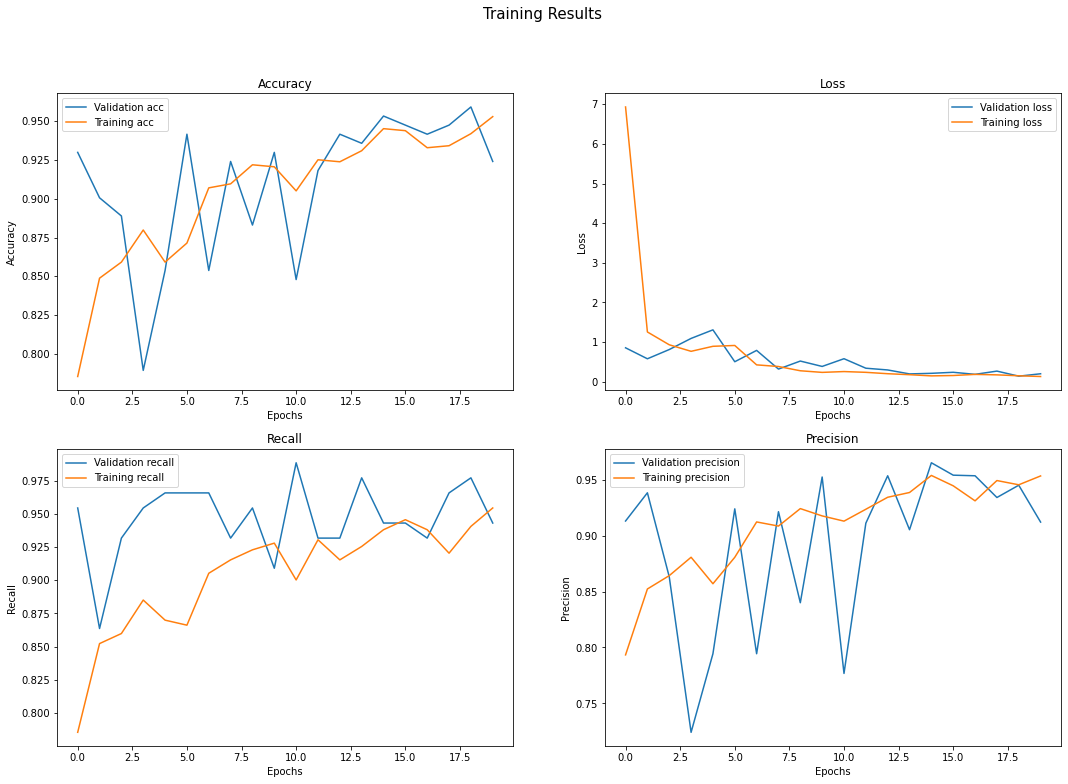

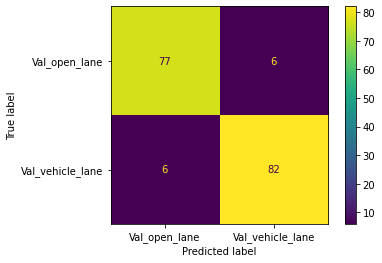

In [53]:
visualize_results(incep_history, incep_transfer_model, incep_train_gen, incep_val_gen)

In [54]:
dump(incep_history.history, open('models/incep_history.pkl', 'wb'))

### ResNet50 as base model

In [55]:
# Make generators
train_datagen = ImageDataGenerator(rescale=1./255, 
                                    validation_split=0.1,
                                    horizontal_flip=True,
                                    rotation_range=20, 
                                    brightness_range=[0.5, 1.5], 
                                    zoom_range=.2)

resnet_train_gen = train_datagen.flow_from_directory(train_dir, subset='training', class_mode='binary')
resnet_val_gen = train_datagen.flow_from_directory(train_dir, subset='validation', class_mode='binary', shuffle=False)

Found 1548 images belonging to 2 classes.
Found 171 images belonging to 2 classes.


In [56]:
# Load ResNet50 model as base
resnet_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

94773248/94765736 [==============================] - 6s 0us/step


In [57]:
# Freeze layers
for layer in resnet_base_model.layers:
    layer.trainable = False

In [58]:
# Check architecture
resnet_base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Add fully connected layers:

In [59]:
# Instantiate model
resnet_transfer_model = models.Sequential()

# Add base model
resnet_transfer_model.add(resnet_base_model)

# Flatten the output layer to 1 dimension
resnet_transfer_model.add(Flatten())

# Add a fully connected layer with 512 hidden units and ReLU activation
resnet_transfer_model.add(Dense(512, activation='relu'))

# Add a final sigmoid layer with 1 node for classification output
resnet_transfer_model.add(Dense(1, activation='sigmoid'))

# Compile
resnet_transfer_model.compile(optimizer='adam', 
                       loss='binary_crossentropy', 
                       metrics=['acc', 'Recall', 'Precision'])

In [60]:
# Train the model
resnet_history = resnet_transfer_model.fit(resnet_train_gen,
                                           epochs=20,
                                           validation_data=resnet_val_gen)

Epoch 1/20
49/49 [==============================] - 339s 7s/step - loss: 3.5868 - acc: 0.5853 - recall: 0.6275 - precision: 0.5889 - val_loss: 0.6586 - val_acc: 0.6433 - val_recall: 0.9886 - val_precision: 0.5918
Epoch 2/20
49/49 [==============================] - 334s 7s/step - loss: 0.6724 - acc: 0.6479 - recall: 0.6616 - precision: 0.6542 - val_loss: 0.7263 - val_acc: 0.5731 - val_recall: 1.0000 - val_precision: 0.5466
Epoch 3/20
49/49 [==============================] - 336s 7s/step - loss: 0.7543 - acc: 0.6447 - recall: 0.6742 - precision: 0.6465 - val_loss: 0.4544 - val_acc: 0.7602 - val_recall: 0.7386 - val_precision: 0.7831
Epoch 4/20
49/49 [==============================] - 295s 6s/step - loss: 0.6606 - acc: 0.6705 - recall: 0.6869 - precision: 0.6749 - val_loss: 0.4868 - val_acc: 0.7427 - val_recall: 0.5341 - val_precision: 0.9400
Epoch 5/20
49/49 [==============================] - 321s 7s/step - loss: 0.5779 - acc: 0.7145 - recall: 0.7083 - precision: 0.7267 - val_loss: 0.494

In [61]:
resnet_transfer_model.save('models/resnet_transfer_model.h5')

Training eval:
49/49 [==============================] - 225s 5s/step - loss: 0.4716 - acc: 0.7681 - recall: 0.7614 - precision: 0.7801

Validation eval:
6/6 [==============================] - 16s 3s/step - loss: 0.4016 - acc: 0.8246 - recall: 0.8750 - precision: 0.8021


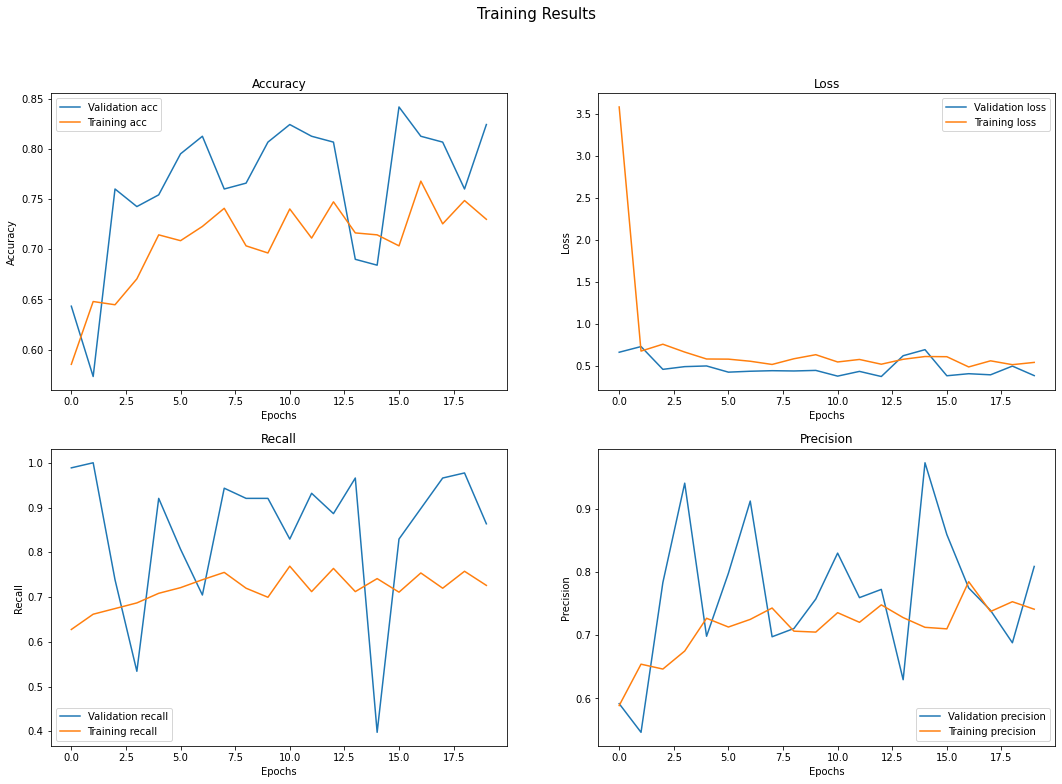

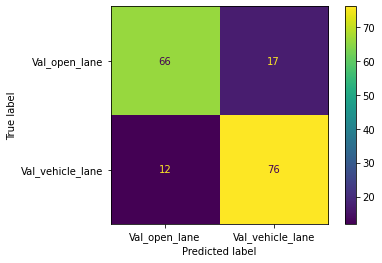

In [62]:
visualize_results(resnet_history, resnet_transfer_model, resnet_train_gen, resnet_val_gen)

In [63]:
dump(resnet_history.history, open('models/resnet_history.pkl', 'wb'))